# SMC in (Gaussian) LDS Notebook

This notebook demonstrates how to use the SMC inference procedure included in JAX-SSM.  

SMC is sampling algorithm for sampling from a posterior over latent states under a fixed model:

$\mathbf{x}^{(i)} \sim p(\cdot | \mathbf{y}, \theta)$

where the latent state is denoted $\mathbf{x} \in \mathcal{X}$, the observed data is denoted $\mathbf{y} \in \mathcal{Y}$, and the model is fixed, indicated by conditioning on a fixed model (or set of model parameter values) $\theta$.  Individual particles are denoted by a superscripted+bracketed index.

Note that while the SMC implementation does support arbitrary, in this simple example we will use the model itself as the proposal, and weight under the likelihood, in what is referred to as a _bootstrap particle filter_ (BPF).  The BPF is arguably the "default" manifestation of SMC.

SMC can also produce an unbiased estimate of the _marginal likelihood_ (ML, also referred to as the _evidence_, or simply the _marginal_), $p(\mathbf{y} | \theta)$.  The LML is a critical and quantative measure of how well the model describes the observed data.

Since the Gaussian LDS can be solved in closed-form and admits Gaussian posteriors, EM will produce an exact evaluation of the evidence and will provide exact posterior distributions.  Therefore, we compare to EM to verify:

- The (qualitative) quality of inferred posteriors over latent state.
- The unbiasedness of the estimate of the marginal likelihood.
- TODO - The variance of the estimate of the marginal likelihood reduces as $\sqrt{N}$, where $N$ is the number of particles used. 

In [1]:
import jax
import importlib
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.scipy as jscipy
import ssm.utils as util

from copy import deepcopy as dc

# SSM imports.
from ssm.lds.models import GaussianLDS
from ssm.inference.smc import smc
from ssm.inference.smc import _plot_single_sweep

# # For testing code:
# import ssm.inference.test_smc as test_smc
# importlib.reload(test_smc)

# Set the initial PRNG key.
key = jax.random.PRNGKey(2)

# 1. Create Gaussian LDS and Observed Data.

#### Set up true model.

In [3]:
latent_dim = 2
emissions_dim = 3

gen_model = lambda _k: GaussianLDS(num_latent_dims=latent_dim, num_emission_dims=emissions_dim, seed=_k, 
                                   dynamics_scale_tril=0.1 * jnp.eye(latent_dim),
                                   emission_scale_tril=1.0 * jnp.eye(emissions_dim),
                                   # initial_state_scale_tril=0.1 * jnp.eye(latent_dim)
                                  )
model = gen_model(jax.random.PRNGKey(3))

#### From the true model, we can sample synthetic data

In [4]:
num_trials = 10
num_timesteps = 100

true_states, data = model.sample(key=jax.random.PRNGKey(4), num_steps=num_timesteps, num_samples=num_trials)

#### Let's view the synthetic data

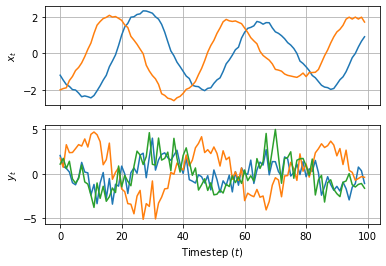

In [5]:
dataset_to_plot = 0
fig, axes = plt.subplots(2, 1, sharex=True, squeeze=True)
axes[0].plot(true_states[dataset_to_plot])
axes[0].grid(True)
axes[0].set_ylabel('$x_t$')
axes[1].plot(data[dataset_to_plot])
axes[1].grid(True)
axes[1].set_ylabel('$y_t$')
plt.xlabel('Timestep ($t$)')
plt.pause(0.1)

# 2. Inference Over Latent State

#### Inference baseline: Use EM to infer the exact posterior over latent state given observes.

In [6]:
# Test against EM (which for the LDS is exact.
em_posterior = jax.vmap(model.e_step)(data)
em_log_marginal_likelihood = model.marginal_likelihood(data, posterior=em_posterior)

#### Inference: Infer the posterior over latent state given observes.

In [7]:
num_particles = 1000  # Number of particles to use in SMC sweeps.
n_repeats = 20        # Number of repeats for each dataset (independent SMC trials).

key, subkey = jax.random.split(key)

# Define a wrapper for SMC sweep using BPF.
repeat_smc = lambda _k: smc(_k, model, data, proposal=None, num_particles=num_particles)

# Compute the posteriors.
smc_posteriors = jax.vmap(repeat_smc)(jax.random.split(subkey, num=n_repeats))

#### Plot the results of inference for a single sweep

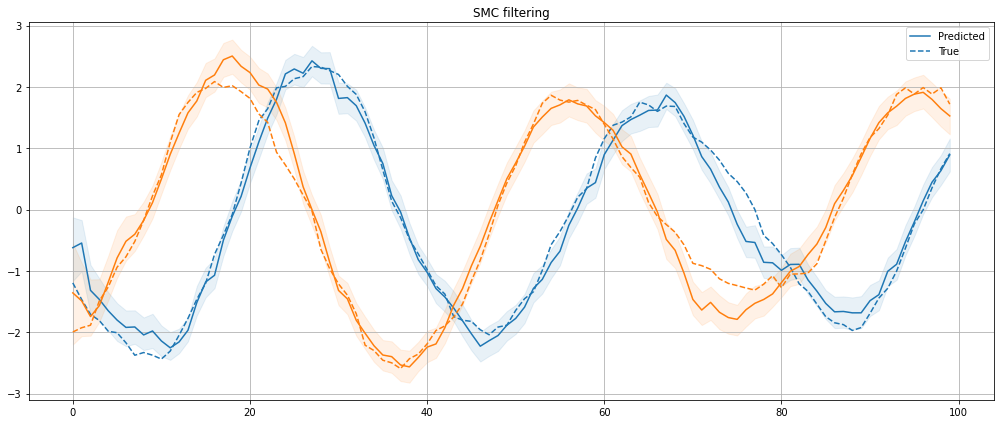

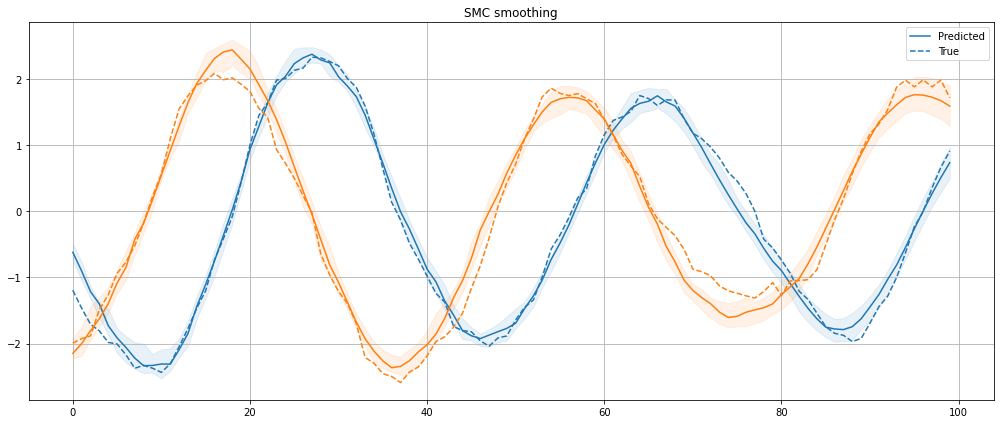

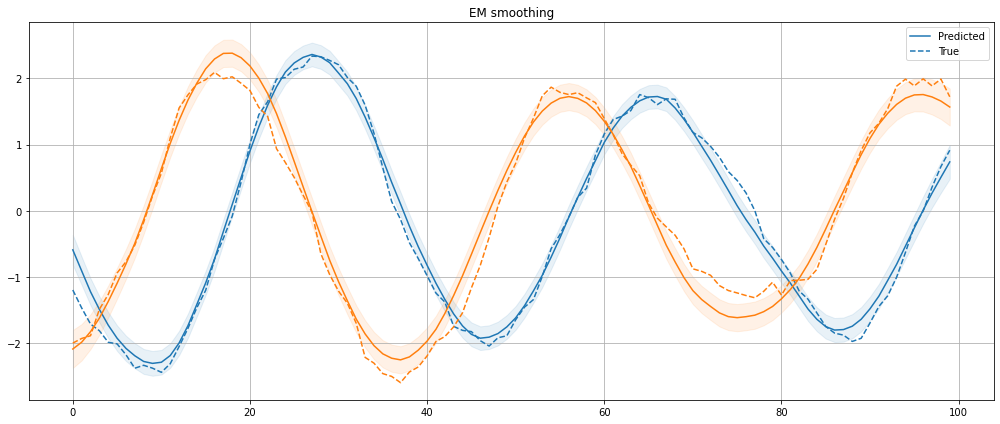

Done


In [8]:
# importlib.reload(test_smc)  # Quick little hack to re-load the plotting scripts.

# Plot the results.
# Which repeat and dataset to plot.
rep = 0
dset = 0

# Pull out the right sweeps and compile statistics.
sweep_true = true_states[dset]
sweep_smc_filtering = smc_posteriors[rep, dset].filtering_particles
sweep_smc_smoothing = smc_posteriors[rep, dset].sample(sample_shape=num_particles, seed=subkey)
sweep_em_mean = em_posterior.mean()[dset]
sweep_em_sds = jnp.sqrt(jnp.asarray([[jnp.diag(__k) for __k in _k] for _k in em_posterior.covariance()]))[dset]
sweep_em_statistics = (sweep_em_mean, sweep_em_mean - sweep_em_sds, sweep_em_mean + sweep_em_sds)

# Plot the SMC and EM distributions.
_plot_single_sweep(sweep_smc_filtering, sweep_true, tag='SMC filtering')
_plot_single_sweep(sweep_smc_smoothing, sweep_true, tag='SMC smoothing')
_plot_single_sweep(sweep_em_statistics, sweep_true, tag='EM smoothing', preprocessed=True)

print('Done')

# 3. Verify ML Estimations

In [9]:
# Quickly just show some of the estimates.
smc_posteriors.log_normalizer[:, 0], em_log_marginal_likelihood[0]

(DeviceArray([-451.95535, -452.6972 , -451.8543 , -451.86407, -452.64188,
              -451.68713, -452.32697, -452.34467, -452.13373, -452.0241 ,
              -452.17303, -453.35645, -452.02368, -452.7031 , -452.79254,
              -452.5781 , -452.13916, -452.235  , -452.78415, -452.5158 ],            dtype=float32),
 DeviceArray(-452.2283, dtype=float32))

This box-and-whisker plot shows the log-marginal likelihoods, as they are generally better scaled and easier to visualize.  Note however that SMC does not produce an unbiased estimate of the log marginal likelihoods (c.f. Jensens inequality), and therefore this is just for back-of-the-envelope verification that the LML estimations are sensible...

The boxes are over the estimate of the LML generated by SMC (of which there are `n_repeats` individual estimates) for each trial (of which there are `num_trials`).

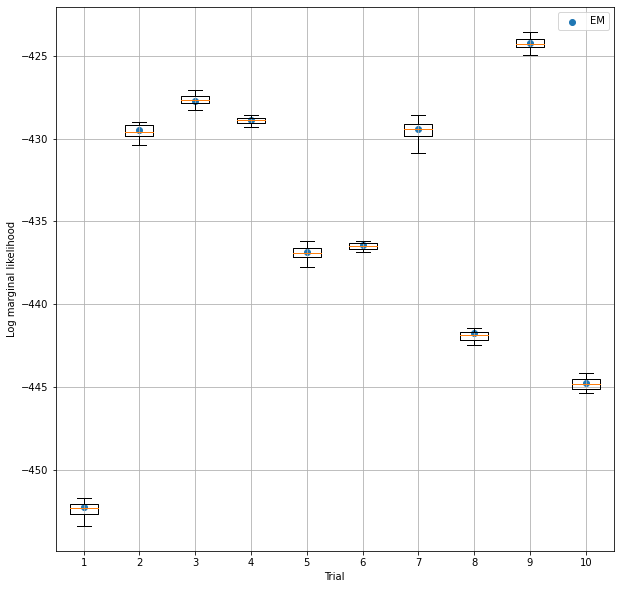

In [10]:
plt.figure(figsize=(10, 10))
plt.boxplot(smc_posteriors.log_normalizer.T, showfliers=False)
plt.grid(True)
plt.scatter(jnp.arange(len(smc_posteriors.log_normalizer.T)) + 1, em_log_marginal_likelihood, label='EM')
plt.legend()
plt.ylabel('Log marginal likelihood')
plt.xlabel('Trial')
plt.pause(0.1)

In [11]:
# Compute the expected log marginals for SMC.
smc_elml = util.lexp(smc_posteriors.log_normalizer, _axis=0)
print(smc_elml)

[-452.26666 -429.52032 -427.64215 -428.87494 -436.79034 -436.44418
 -429.44507 -441.85294 -424.19824 -444.73282]


In [12]:
print('|-----------------------------------------|')
print('| Trial, i: |    log E [p(y_i | theta)]   |')
print('|           |-----------------------------|')
print('|           |      SMC     |      EM      |')
print('|-----------|--------------|--------------|')
for _idx, _smc, _em in zip(range(len(smc_elml)), smc_elml, em_log_marginal_likelihood):
    print('|   {: >3d}  '.format(_idx),
          '  |  {: >8.2f} '.format(_smc), 
          '  |  {: >8.2f} '.format(_em), 
          '  |  ')
print('|-----------------------------------------|')

|-----------------------------------------|
| Trial, i: |    log E [p(y_i | theta)]   |
|           |-----------------------------|
|           |      SMC     |      EM      |
|-----------|--------------|--------------|
|     0     |   -452.27    |   -452.23    |  
|     1     |   -429.52    |   -429.50    |  
|     2     |   -427.64    |   -427.74    |  
|     3     |   -428.87    |   -428.90    |  
|     4     |   -436.79    |   -436.82    |  
|     5     |   -436.44    |   -436.45    |  
|     6     |   -429.45    |   -429.43    |  
|     7     |   -441.85    |   -441.75    |  
|     8     |   -424.20    |   -424.24    |  
|     9     |   -444.73    |   -444.76    |  
|-----------------------------------------|


In [13]:
lml_diff = smc_elml - em_log_marginal_likelihood
print('Raw difference in LML: ', '  '.join(['{: >5.2f}'.format(_x) for _x in lml_diff]))

ml_diff = jnp.exp(lml_diff)
print('Raw ratios of ML:      ', '  '.join(['{: >5.2f}'.format(_x) for _x in ml_diff]))

mml_diff = jnp.mean(ml_diff)
print()
print('Expected ratio in ML:  ', mml_diff)
print('(should =1, <1 implies evidence is underestimated, >1 implies evidence is overestimated.)')


Raw difference in LML:  -0.04  -0.02   0.10   0.03   0.03   0.00  -0.02  -0.10   0.04   0.03
Raw ratios of ML:        0.96   0.98   1.11   1.03   1.03   1.00   0.98   0.90   1.05   1.03

Expected ratio in ML:   1.006223
(should =1, <1 implies evidence is underestimated, >1 implies evidence is overestimated.)


---

---

# Experimental Stuff

# A. Analyse convergence of ML estimator across particles

In [14]:
# n_repeats = 20                              # Number of repeats for each dataset (independent trials).
# vec_num_particles = jnp.asarray([10, 50, 100, 500, 1000])  # Number of particles to use in SMC sweeps.

# key, subkey = jax.random.split(key)

# # Define a wrapper for SMC sweep using BPF.
# repeat_smc_wk_wp = lambda __k, __p: smc(__k, model, data, proposal=None, num_particles=__p)

# # Note that because different numbers of particles entail different variable
# # dimensions at execution time, we need to explicitly iterate over the different
# # numbers of particles.
# particle_lml = []
# for _p in vec_num_particles:
#     key, subkey = jax.random.split(key)
#     _lmls = jax.vmap(repeat_smc_wk_wp, in_axes=(0, None))(jax.random.split(subkey, num=n_repeats), _p)
#     particle_lml.append(_lmls[1])

# particle_lml = jnp.asarray(particle_lml)

In [15]:
# lml_error = particle_lml - em_log_marginal_likelihood
# lml_variance = jnp.mean(jnp.var(jnp.exp(error) - 1, axis=1), axis=1)

# plt.plot(vec_num_particles, lml_variance)
# # plt.yscale('log')

# print(lml_variance)

# B. Verify ML Estimations across models

What we did above was conditioned on a single model ($\theta$), and so we need to repeat this estimation across models.  We will therefore average over trials and repeats, conditioned on individual models.

In [16]:
# def test_single_model(key):
    
#     # Generate a new model and data.
#     key, subkey = jax.random.split(key)
#     model = gen_model(subkey)
#     key, subkey = jax.random.split(key)
#     true_states, data = model.sample(key=subkey, num_steps=num_timesteps, num_samples=num_trials)

#     # Test against EM (which for the LDS is exact.
#     em_posterior = jax.vmap(model.e_step)(data)
#     em_log_marginal_likelihood = model.marginal_likelihood(data, posterior=em_posterior)

#     # Compute the posteriors using SMC.
#     key, subkey = jax.random.split(key)
#     repeat_smc = lambda _k: smc(_k, model, data, proposal=None, num_particles=num_particles)
#     smc_posteriors = jax.vmap(repeat_smc)(jax.random.split(subkey, num=n_repeats))
#     log_marginal_likelihood = smc_posteriors.log_normalizer
    
#     return log_marginal_likelihood, em_log_marginal_likelihood

In [17]:
# num_timesteps = 100    # Number of timesteps in each trial.
# num_particles = 100    # Number of particles to use in SMC sweeps.
# num_trials = 20        # Number of trials to draw per model.
# n_repeats = 10         # Number of repeats for each dataset (independent SMC runs).
# n_models_to_test = 10   # Number of random models to test.

# # Sometimes vmap causes the swap file to be thrashed. 
# smc_lmls, em_lmls = [], []
# for _k in jax.random.split(key, num=n_models_to_test):
#     key, subkey = jax.random.split(key)
#     ret = test_single_model(_k)
#     smc_lmls.append(ret[0])
#     em_lmls.append(ret[1])
# smc_lmls = jnp.asarray(smc_lmls)
# em_lmls = jnp.asarray(em_lmls)

# # key, subkey = jax.random.split(key)
# # smc_lmls, em_lmls = jax.vmap(test_single_model)(jax.random.split(key, num=n_models_to_test))


In [18]:
# mean_smc_lml = jscipy.special.logsumexp(smc_lmls, axis=(1, 2)) - jnp.log(jnp.prod(jnp.asarray(smc_lmls.shape[1:])))
# mean_em_lml = jscipy.special.logsumexp(em_lmls, axis=1) - jnp.log(jnp.prod(jnp.asarray(em_lmls.shape[1:])))

# # TODO - not quite sure whether this is a sensible thing to chart.

# print('|-------------------------------------|')
# print('| Model, i: | log E [ p( theta_i ) ]  |')
# print('|           |-------------------------|')
# print('|           |     SMC    |     EM     |')
# print('|-----------|------------|------------|')
# for _idx, _smc, _em in zip(range(len(mean_smc_lml)), mean_smc_lml, mean_em_lml):
#     print('|   {: >3d}  '.format(_idx),
#           '  |  {: >5.2f}'.format(_smc), 
#           '  |  {: >5.2f}'.format(_em), 
#           '  |  ')
# print('|-------------------------------------|')


In [19]:
# lml_diff = mean_smc_lml - mean_em_lml
# print('Raw difference in LML: ', '  '.join(['{: >5.2f}'.format(_x) for _x in lml_diff]))

# ml_diff = jnp.exp(lml_diff)
# print('Raw ratios of ML:      ', '  '.join(['{: >5.2f}'.format(_x) for _x in ml_diff]))

# mml_diff = jnp.mean(ml_diff)
# print()
# print('Expected ratio in ML:  ', mml_diff)
# print('(should =1, <1 implies evidence is underestimated, >1 implies evidence is overestimated.)')



# C - Random Stuff.

In [20]:
# smc_posteriors